# Weather Analytics - OCC
### Camilo Quiroga / Operational Performance & Analytics Coordinator





<div class="alert alert-block alert-info" >
    
### Descripción:
Este Notebook tiene como objetivo analizar el comportamiento meteorológico de los aeropuertos operados por <a href="www.vivaair.com">Viva Air </a> teniendo en cuenta la información suministrada por
<a href="https://mesonet.agron.iastate.edu/ASOS/">IOWA State University - MESONET</a>. Se crearán mapas de calor que permitan detectar patrones de difirentes variables meteorológicas para cada uno de los meses en distintas franjas horarias.

</div>    

In [1]:
import os, shutil, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#!conda install folium -c conda-forge
import folium 

#conda install -c anaconda seaborn
import seaborn as sns

C:\Users\camilo.quiroga\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Parametros

* **Countries (dictionary):** Listado de aeropuertos a analizar. 
* **Years (integer):** Cantidad de años de muestra para el análisis. Tenga en cuenta que aeropuertos de EU capturan información cada 10 min, mientras que en otras partes del mundo se captura cada hora
* **Save_heatmaps (Boolean):** Parametro que índica si se deben crear carpetas por aeropuertos para guardar el detalle de los gráficos de calor generados (Temperatura, Visibilidad, Tormenta, Lluvia, Restricción Operacional)
* **Save_summ (Boolean):** Parametro que índica si se crea un archivo de excel con el resumen de los análisis realizados

In [2]:
#Parameters

#Countries={Key1:[list of airports],Key2:[list of airports]}

Countries={'test':['BOG','MDE','LIM']} 

'''
Countries={
    'CO':['ADZ','AXM','BAQ','BOG','BGA','CLO','CTG','CUC','EYP','LET','MDE','MTR','PEI','RCH','SMR','VUP'],
    'PE':['AQP','CJA','CIX','CUZ','IQT','JAE','JUL','LIM','PIU','TCQ','TYL','TPP'],
    'EC':['GYE','UIO','LTX','CUE'],
    'US':['IAH','MIA','MCO','JFK','BGR'],
    'MX':['CUN','MEX'],
    'INT':['CUR','SCL','PUJ','EZE']
}
'''

Years=5

Save_heatmaps=True
Save_summ=True



#Pendiente grafico de visibilidad últimos 30 dias

### 2. Datos

* <a href="https://ourairports.com/data/">Airports data</a>
* <a href="https://mesonet.agron.iastate.edu/ASOS/">IOWA State University - MESONET</a>

In [3]:
#Airports Data Frame // Get data from our airports

airports=pd.read_csv("http://ourairports.com/data/airports.csv")
airports=airports[(airports["scheduled_service"]=='yes') & (airports["type"].str.contains("medium") | airports["type"].str.contains("large"))]
airports.drop(["id", "ident", "iso_region","continent","type","scheduled_service","local_code","home_link","wikipedia_link","keywords"],axis=1,inplace=True)

request=[]
for i in Countries:
    for j in Countries.get(i):
        request.append(j)
        
airports=airports[airports['iata_code'].isin(request)]
airports.set_index("iata_code",inplace=True)

In [4]:
airports.head(20)

,name,latitude_deg,longitude_deg,elevation_ft,iso_country,municipality,gps_code
iata_code,,,,,,,
BOG,El Dorado International Airport,4.70159,-74.146900,8361.0,CO,Bogota,SKBO
MDE,Jose Maria Córdova International Airport,6.16454,-75.423100,6955.0,CO,Medellín,SKRG
LIM,Jorge Chávez International Airport,-12.02190,-77.114305,113.0,PE,Lima,SPJC


In [5]:
#Airports Visualization using folium

latitude=airports['latitude_deg'].median()
longitude=airports['longitude_deg'].median()
zoom=5

vivaair_map = folium.Map(location = [latitude, longitude], zoom_start = zoom)

for lat, lng, label in zip(list(airports.latitude_deg),list(airports.longitude_deg),list('('+airports.index+') '+airports.municipality)):
    folium.Marker([lat, lng], popup=label).add_to(vivaair_map) 

vivaair_map.save(outfile= "vivaair_map.html")
vivaair_map



In [6]:
#Get data from IOWA State University - Mesonet
def getdata(stationslist,year=5,df=airports,adjUTC=-5):
    
    #stationlist: Listado de estaciones 
    if year<=0:
        year=1
    
    url="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

    for i in stationslist:
        url=url+"station="+str(df.at[i,'gps_code'])+"&"

    #Temperauture (°C)//Wind Direction//Wind Speed (Knots)//Visibility (miles)
    #Cloud Coverage//Cloud Height Level (ft)//Present Wx Codes
    
    url=url+"data=tmpc&data=drct&data=sknt&data=vsby&data=skyl1&data=wxcodes&"
    
    date2=datetime.datetime.utcnow().date() - datetime.timedelta(days=1)
    y2=str(date2.year)
    m2=str(date2.month)
    d2=str(date2.day)
    y1=str(date2.year-year)
    
    #Date from-to
    url=url+"&year1="+y1+"&month1=1&day1=1&year2="+y2+"&month2="+m2+"&day2="+d2
    
    #Missing valueas as null, download directly as txt fiile    
    url=url+"&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=null&trace=null&direct=yes&report_type=1&report_type=2"
    
    data=pd.read_csv(url)
    
    data["valid"]=pd.to_datetime(data["valid"])
    data["Year"]= pd.DatetimeIndex(data["valid"]).year
    data["Month"]= pd.DatetimeIndex(data["valid"]).month
    data["Hour UTC"]= pd.DatetimeIndex(data["valid"]).hour
    data["Hour LT"]= pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC)).hour
    data["Rain"]=data['wxcodes'].str.contains('RA').fillna(False).astype(int)*100
    data["Fog-Brume"]=(data['wxcodes'].str.contains('FG')|data['wxcodes'].str.contains('BR')).fillna(False).astype(int)*100
    data["Thunder"]=data['wxcodes'].str.contains('TS').fillna(False).astype(int)*100
    data["Snow"]=data['wxcodes'].str.contains('SN').fillna(False).astype(int)*100
    data["Op constraint"]=((data["Fog-Brume"]==100) | (data["Thunder"]==100)).astype(int)*100
    data.rename(columns={"station":"OACI","tmpc": "Temperature","drct": "Wind Dir","vsby":"H Vsby","skyl1":"V Vsby","sknt": "Wind"},inplace=True)
    data.drop(['valid', 'wxcodes'], axis=1, inplace=True)
    
    df2=df['gps_code'].to_frame().reset_index()
    data=pd.merge(left=data, right=df2, how='left', left_on='OACI', right_on='gps_code')
    
    data.rename(columns={"iata_code":"IATA"},inplace=True)
    data['IATA']=data['IATA'].fillna(data['OACI'])
    data.drop(['gps_code'], axis=1, inplace=True)
    
    data=data[['IATA','OACI', 'Temperature', 'Wind Dir', 'Wind', 'H Vsby', 'V Vsby',
               'Year','Month', 'Hour UTC', 'Hour LT', 'Rain', 'Fog-Brume', 'Thunder', 'Snow','Op constraint']]
    
    return data
    

In [7]:
data=getdata(request,year=5)
data

,IATA,OACI,Temperature,Wind Dir,Wind,H Vsby,V Vsby,Year,Month,Hour UTC,Hour LT,Rain,Fog-Brume,Thunder,Snow,Op constraint
0,BOG,SKBO,13.0,80.0,12.0,6.21,2300.0,2015,1,0,19,0,0,0,0,0
1,LIM,SPJC,21.0,170.0,10.0,6.21,1100.0,2015,1,0,19,0,0,0,0,0
2,MDE,SKRG,18.0,40.0,6.0,6.21,1800.0,2015,1,0,19,0,0,0,0,0
3,BOG,SKBO,12.0,110.0,10.0,6.21,2300.0,2015,1,1,20,0,0,0,0,0
4,MDE,SKRG,17.0,40.0,4.0,6.21,1200.0,2015,1,1,20,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146159,MDE,SKRG,20.0,60.0,8.0,6.21,2000.0,2020,4,22,17,0,0,0,0,0
146160,BOG,SKBO,17.0,330.0,6.0,6.21,1700.0,2020,4,22,17,0,0,100,0,100
146161,MDE,SKRG,19.0,50.0,8.0,6.21,2000.0,2020,4,23,18,0,0,0,0,0
146162,LIM,SPJC,22.0,160.0,12.0,6.21,NaN,2020,4,23,18,0,0,0,0,0


In [8]:
from datetime import date

if Save_heatmaps==True or Save_heatmaps==True:
    dir = os.getcwd()+"/"+ str(date.today().strftime("%y%m%d"))+" Airport Heatmaps"

    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
print(dir)

C:\Users\camilo.quiroga\Documents\GitHub\Weather-Tool-Analytics-OCC/200426 Airport Heatmaps


In [9]:
dataframes={}
group={}
columns=['Temperature','Wind','Rain','Fog-Brume','Thunder','Snow','Op constraint']
columns_title=['Temperature (°C)','Wind (knots)','% Rain','% Fog-Brume','% Thunder','% Snow','% Op constraint']
hour=['Hour UTC','Hour LT']

for i in request:
    for j in hour:
        for k in columns:
            dataframes[(i,j,k)]=data[['IATA','Month',j,k]][data[['IATA','Month',j,k]]['IATA']==i]
            group[(i,j,k)]= round(dataframes.get((i,j,k)).groupby(['Month',j]).mean().unstack().fillna(0).T,2)

#dataframes

C:\Users\camilo.quiroga\Documents\GitHub\Weather-Tool-Analytics-OCC/200426 Airport Heatmaps/BOG
C:\Users\camilo.quiroga\Documents\GitHub\Weather-Tool-Analytics-OCC/200426 Airport Heatmaps/MDE


C:\Users\camilo.quiroga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\Users\camilo.quiroga\Documents\GitHub\Weather-Tool-Analytics-OCC/200426 Airport Heatmaps/LIM


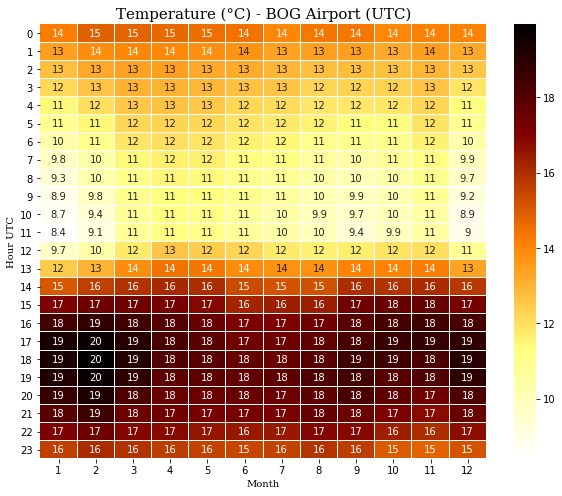

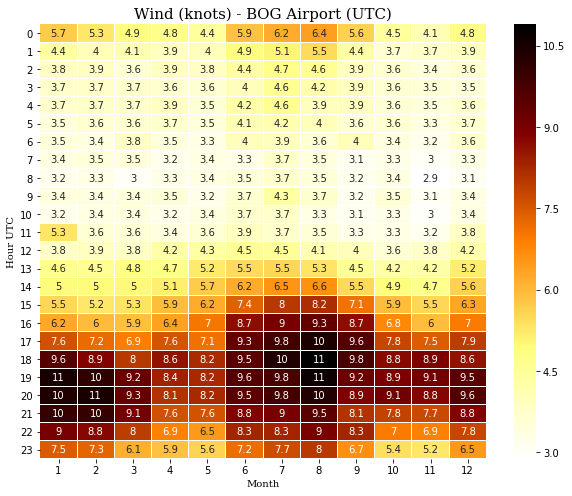

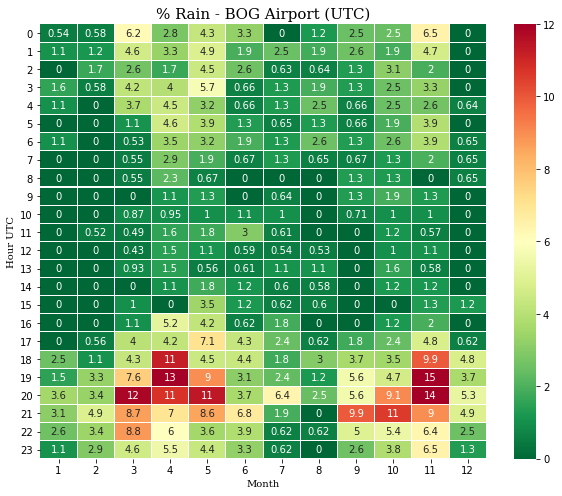

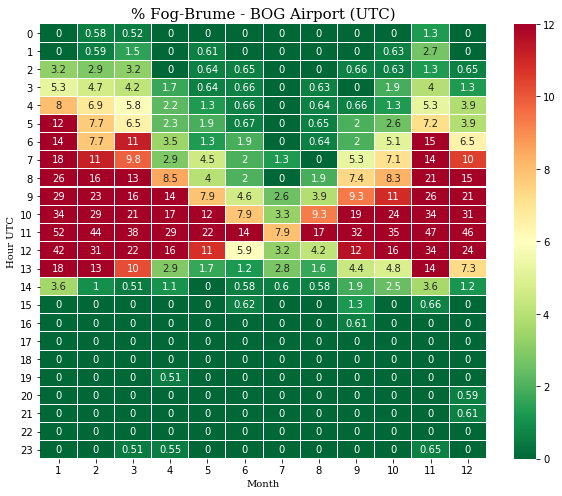

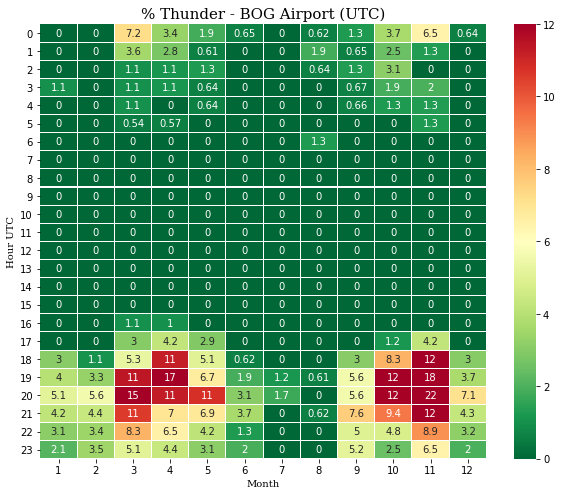

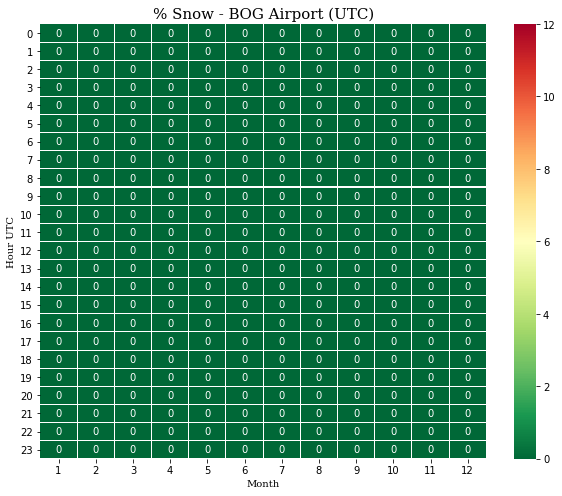

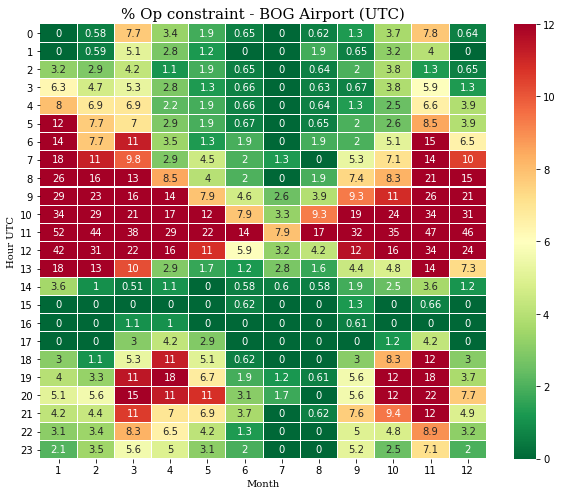

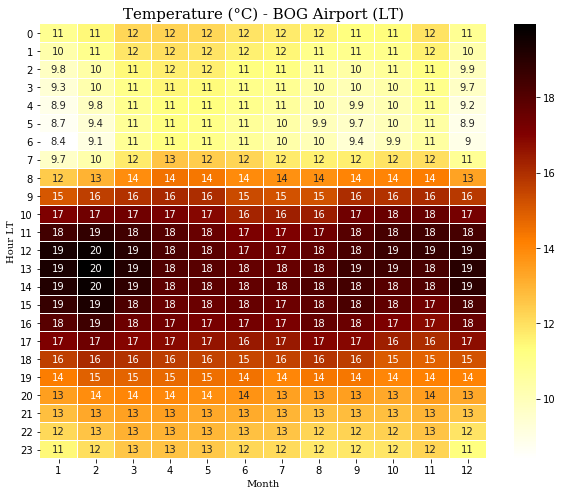

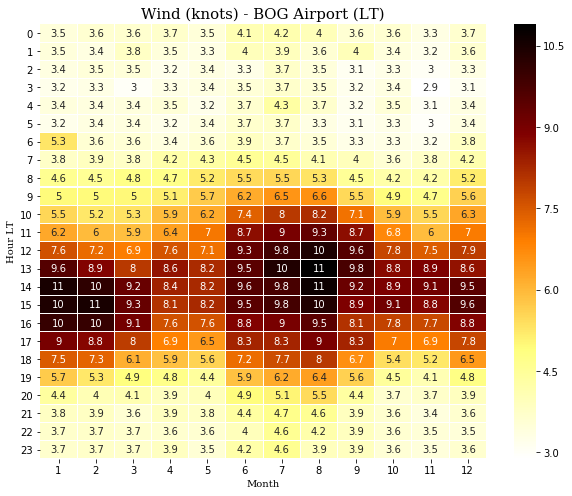

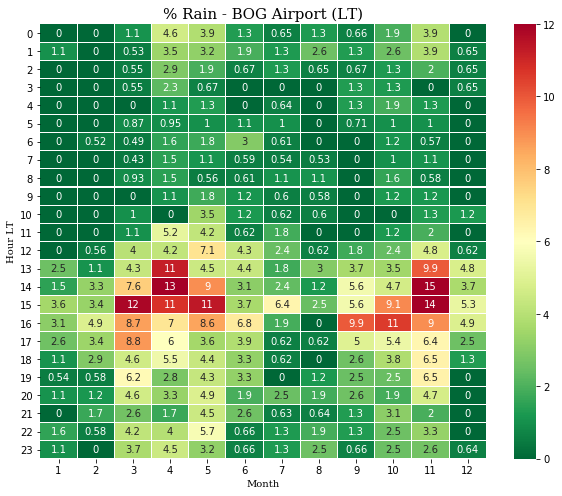

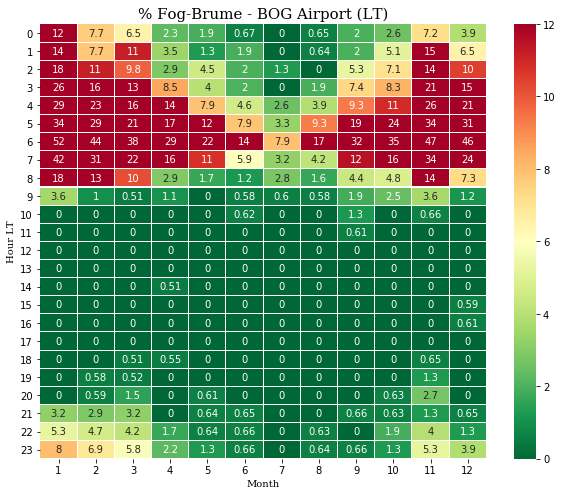

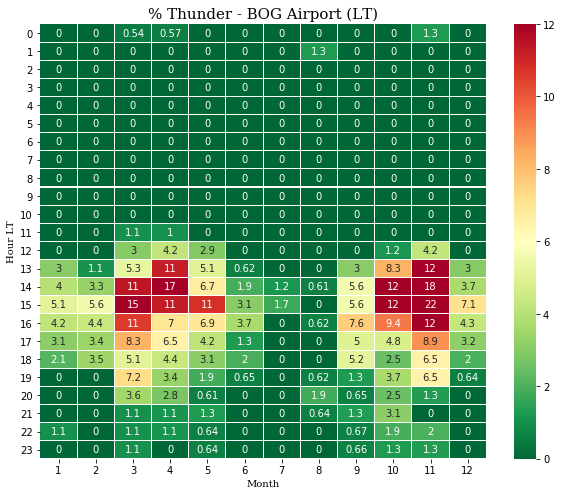

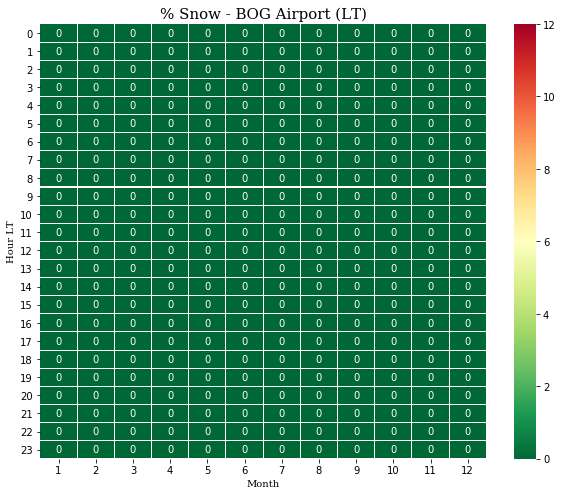

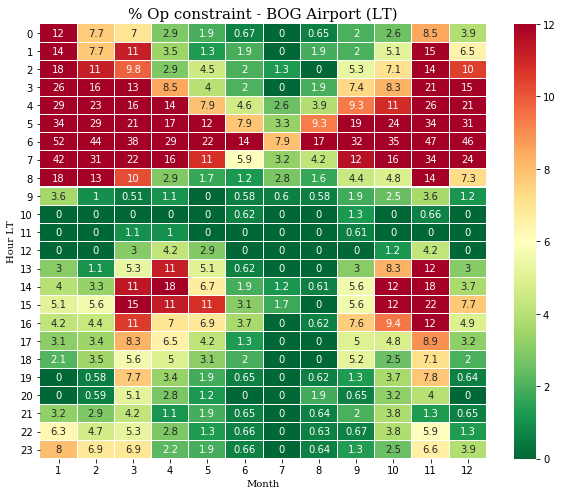

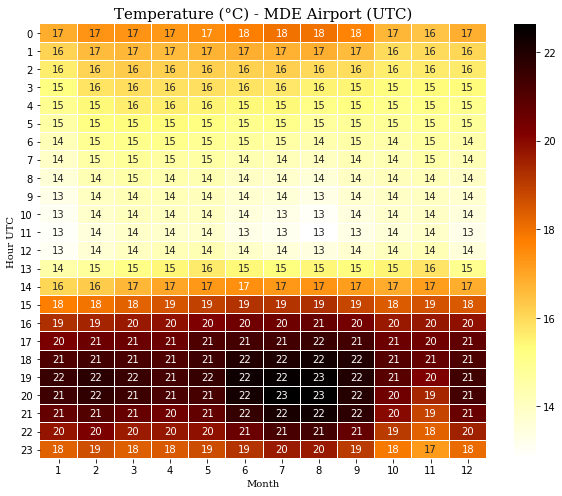

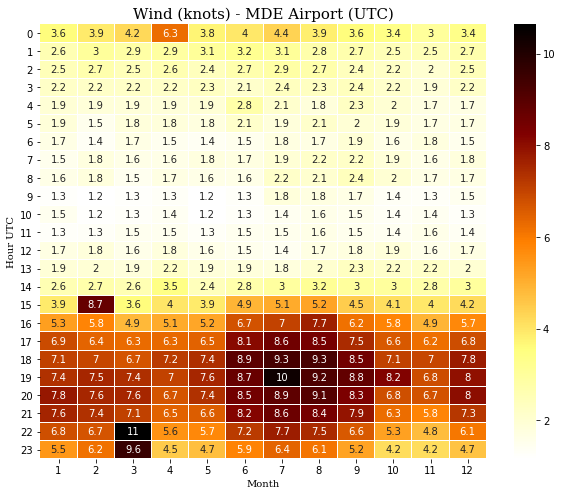

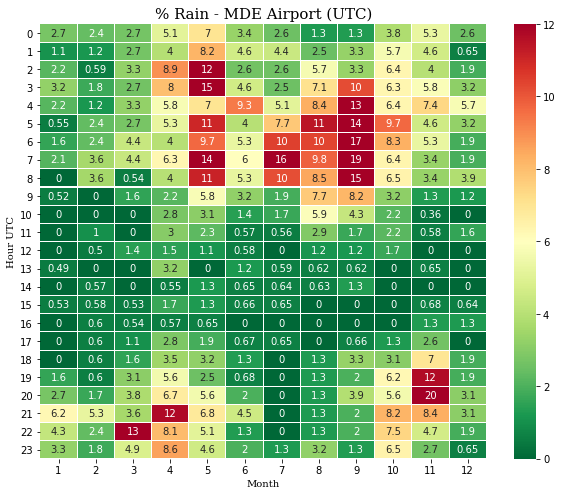

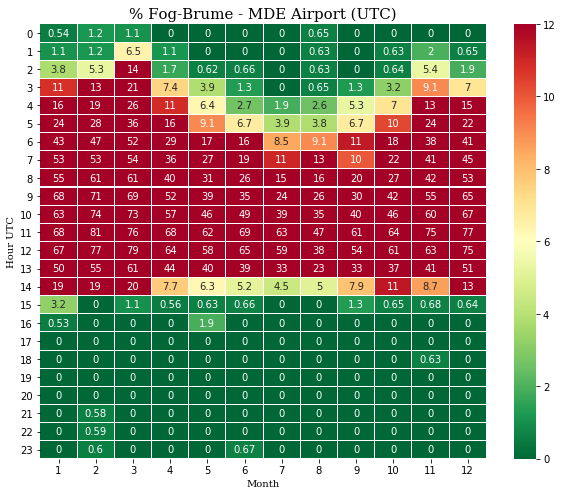

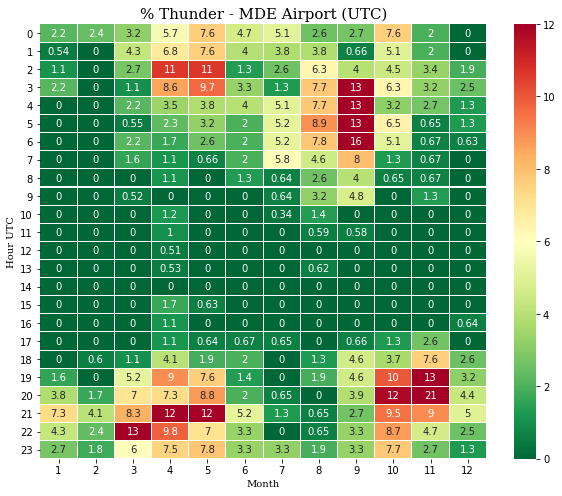

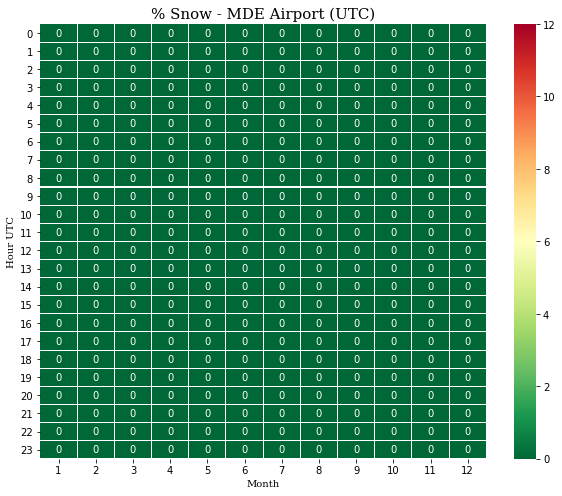

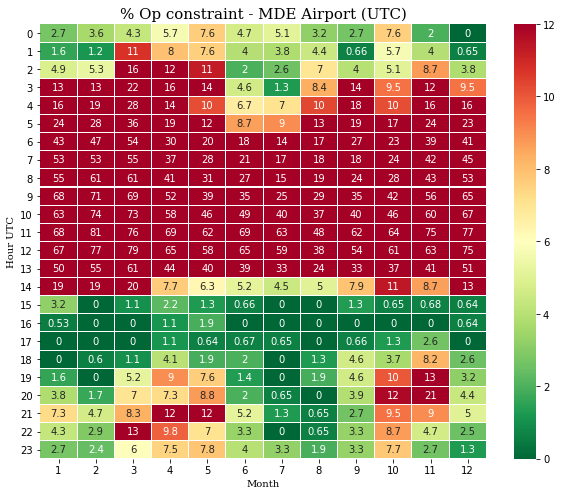

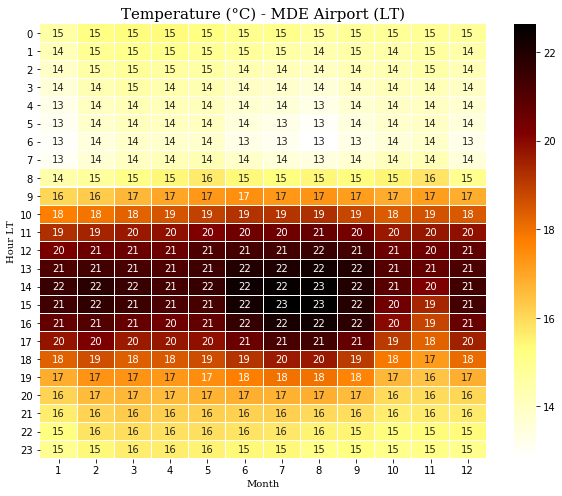

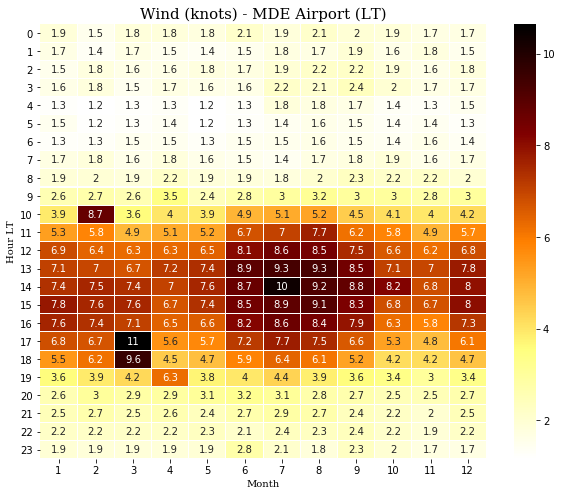

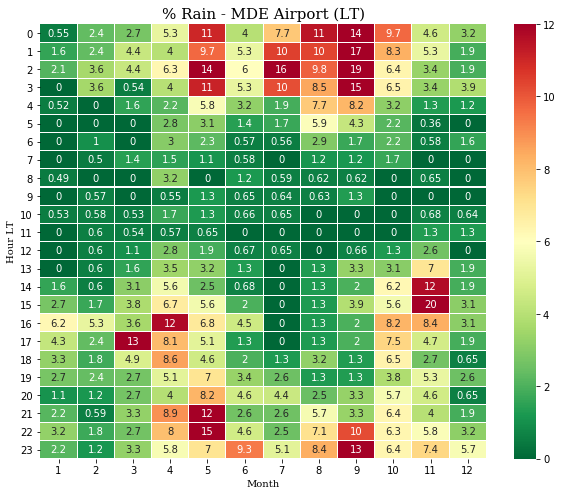

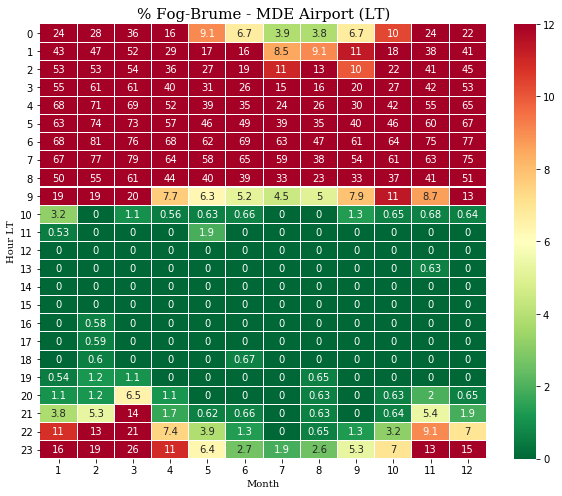

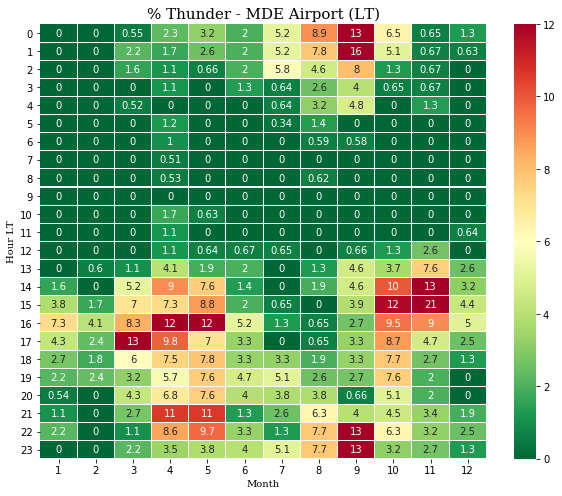

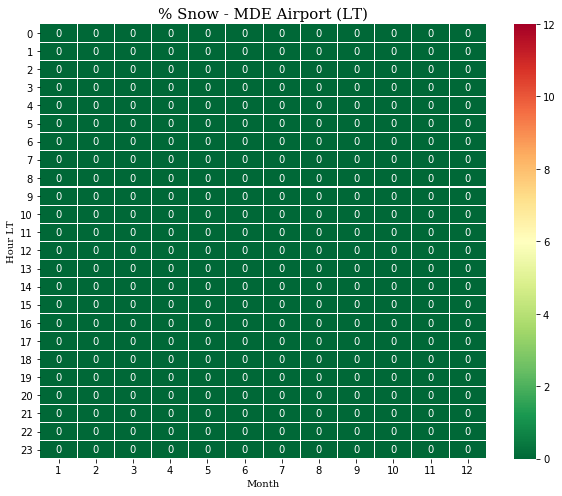

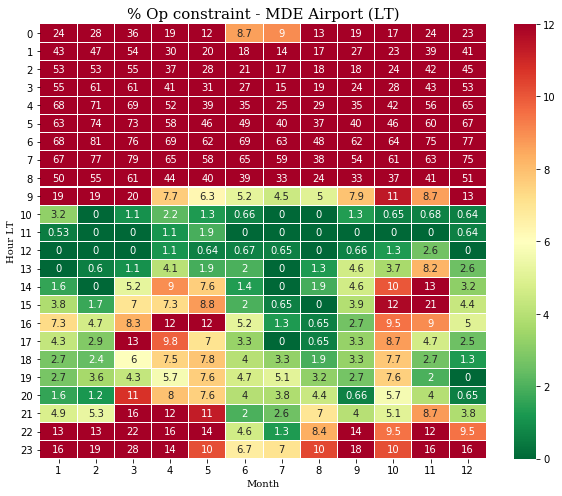

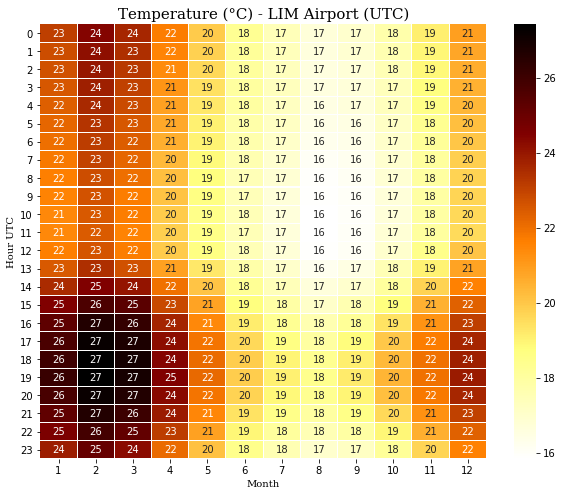

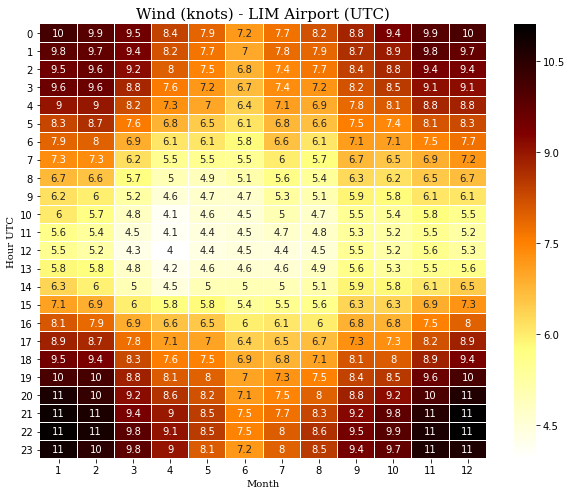

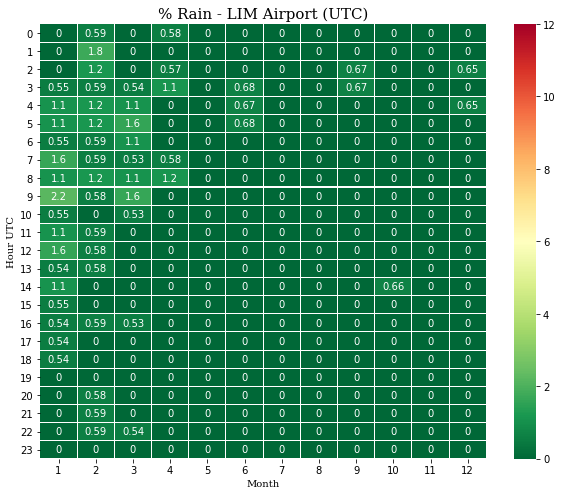

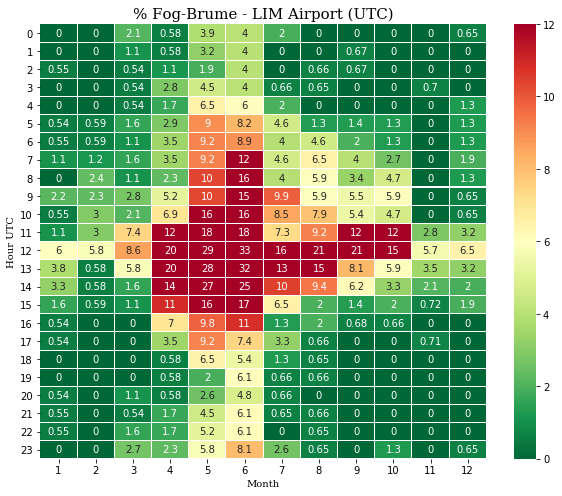

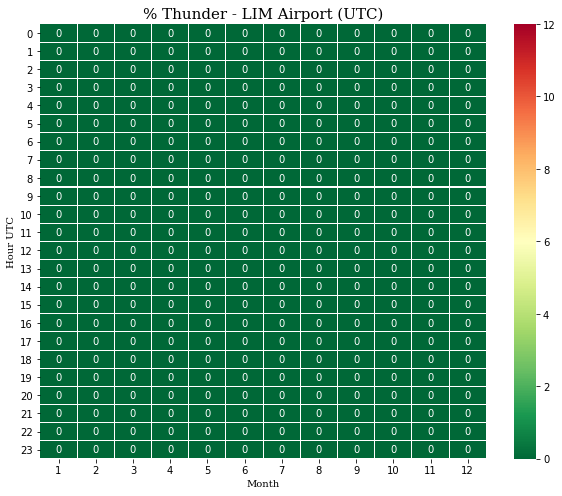

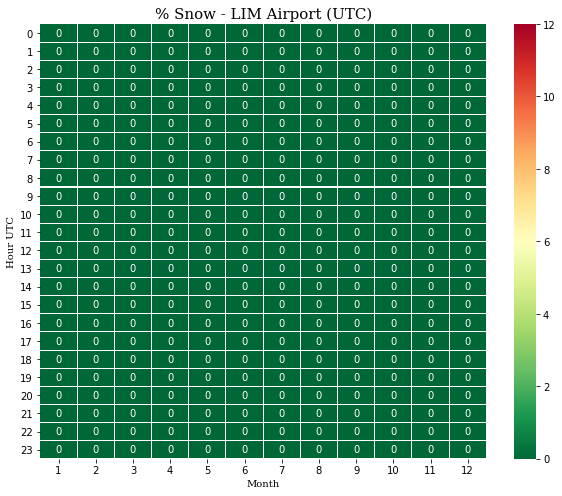

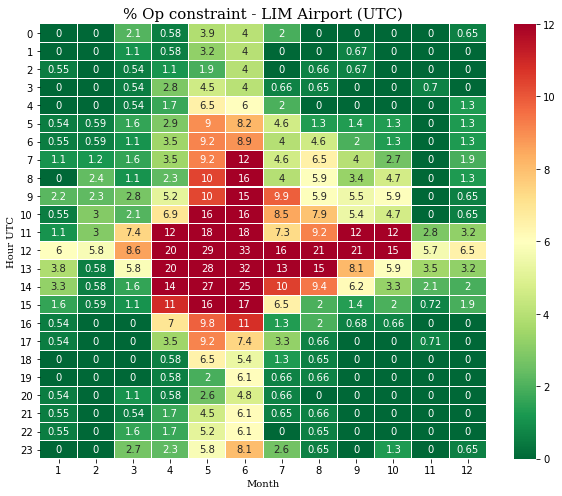

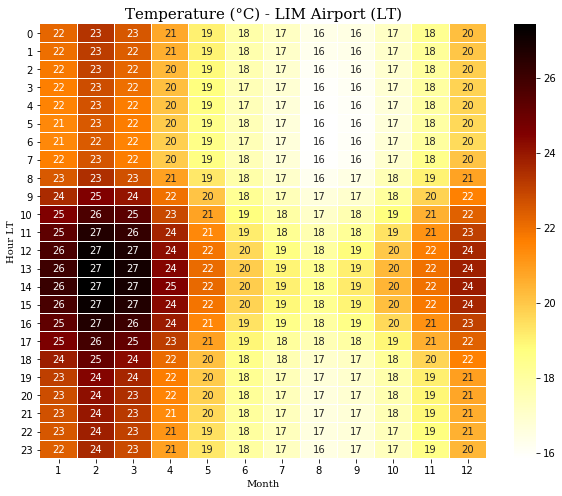

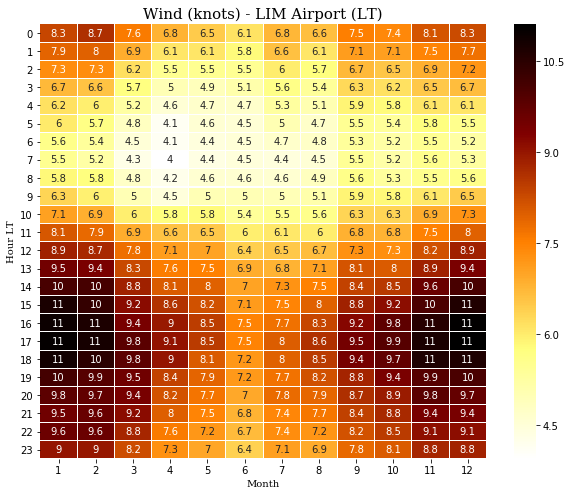

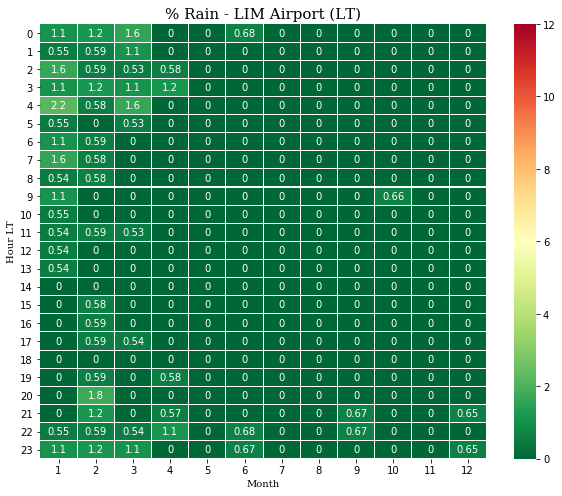

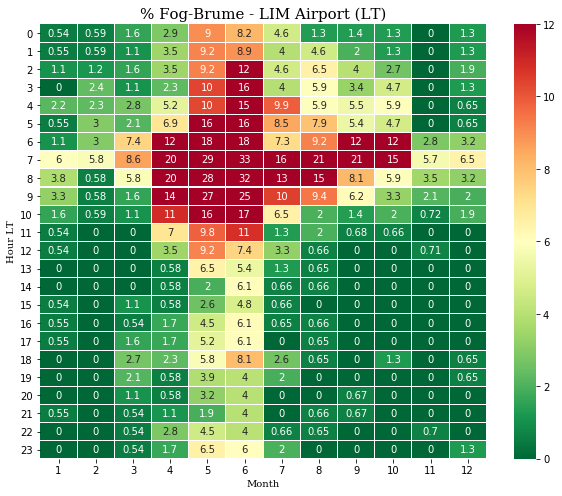

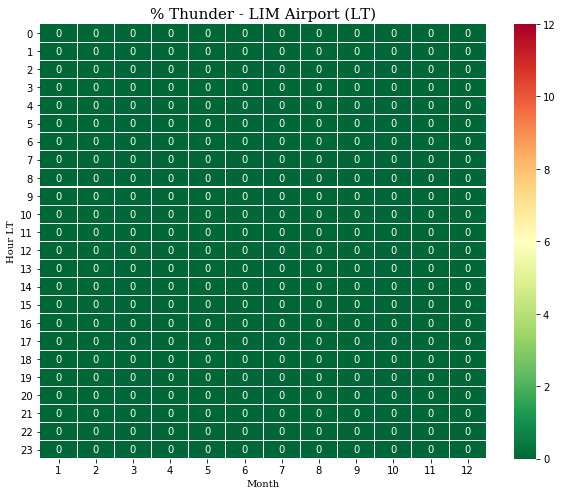

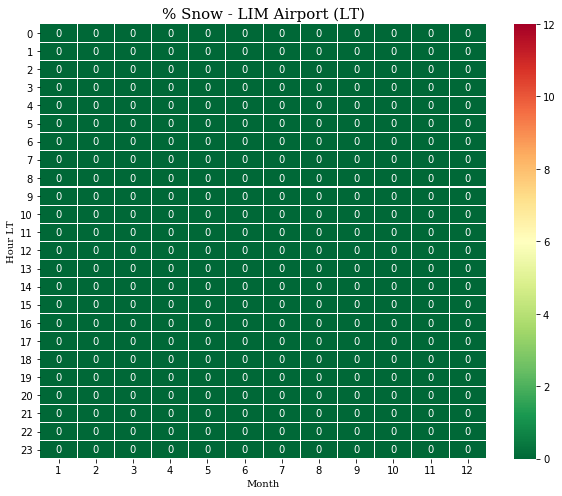

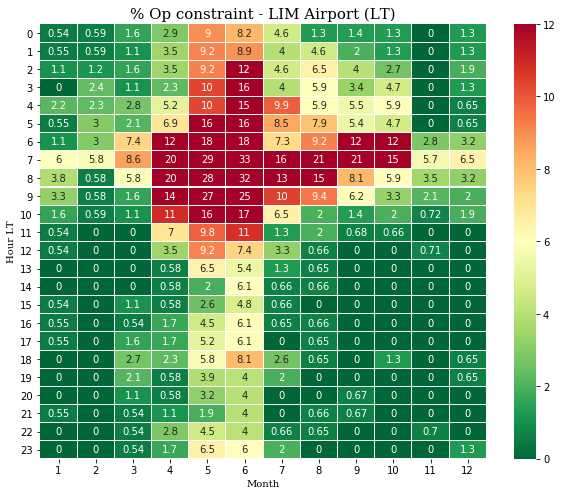

In [10]:
#Generate and Save Heatmpas by airport

vmin=0
vmax=12
ax={}
f={}

for i in request:
    if Save_heatmaps==True:
        dir2=str(dir)+"/"+str(i)
        print(dir2)
        if os.path.exists(dir2):
            shutil.rmtree(dir2)
        os.makedirs(dir2)
    for j in hour:
        for k in columns:
            ax[(i,j,k)]= plt.figure(figsize=(10, 8))
            if k=="Temperature" or k=="Wind":
                ax[(i,j,k)]=sns.heatmap(group.get((i,j,k)),cmap="afmhot_r",annot=True,linewidths=.01)
            else:
                ax[(i,j,k)]=sns.heatmap(group.get((i,j,k)),vmin=vmin, vmax=vmax,cmap="RdYlGn_r",annot=True,linewidths=.01)
            
            ax[(i,j,k)].set_yticklabels(np.arange(0,24))
            ax[(i,j,k)].set_ylabel(j,fontsize=10,family="serif")
            ax[(i,j,k)].set_xlabel("Month",fontsize=10,family="serif")
            ax[(i,j,k)].set_title(columns_title[columns.index(k)]+" - "+ i +" Airport ("+j.replace("Hour ","")+")",fontsize=15,family="serif")
            
            if Save_heatmaps==True:
                my_file=j.replace("Hour ","")+" "+columns_title[columns.index(k)]+" - "+ i +" Airport"+'.png'
                plt.savefig(os.path.join(dir2, my_file))  
